In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from chatsky_llm_autoconfig.settings import EnvSettings
env_settings = EnvSettings()
env_settings.GENERATION_MODEL_NAME

'o1-mini'

In [3]:
from datasets import load_dataset
%load_ext autoreload
%autoreload 2

from chatsky_llm_autoconfig.graph import BaseGraph, Graph
from chatsky_llm_autoconfig.schemas import DialogueGraph
from chatsky_llm_autoconfig.dialogue import Dialogue, DialogueMessage

from chatsky_llm_autoconfig.algorithms.three_stages_1 import ThreeStagesGraphGenerator as Generator
from chatsky_llm_autoconfig.algorithms.three_stages_1i import ThreeStagesGraphGenerator as GeneratorI
from chatsky_llm_autoconfig.algorithms.three_stages_0i import ThreeStagesGraphGenerator as GeneratorI0
from chatsky_llm_autoconfig.algorithms.append_chain import AppendChain

from chatsky_llm_autoconfig.metrics.automatic_metrics import is_same_structure, triplet_match

import json
import matplotlib.pyplot as plt

/home/olshevskaya/miniconda3/envs/conda_env_py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


In [4]:
graph_generator = Generator("gpt-3.5-turbo") # To generate 1st graph from one dialogue
graph_generator_llm_emb = GeneratorI() # To add dialogue to existing graph: adding nodes with LLM and edges with embedder
graph_generator_llm = GeneratorI0() # To add dialogue to existing graph with LLM
graph_generator_llm_2 = AppendChain() # To add (append) dialogue to existing graph with LLM (the second approach)

# Test on data from GEM/schema_guided_dialog (RentalCars_3)

In [111]:
dataset = load_dataset("GEM/schema_guided_dialog", trust_remote_code=True)

# dialogues about rental cars
new_data=[]
topic = 'RentalCars_3'
for d in [el for el in dataset['test'] if el['service'] == topic]:
    exist = [[{'text':"Hello! How can I help you?", "participant":"assistant"}]] + [[{"text":u,"participant":"user"},{"text":a,"participant":"assistant"},] for u,a in zip(d['context'][0:-1:2],d['context'][1::2])] + [[{'text':d['prompt'], "participant":"user"}, {'text':d['target'], "participant":"assistant"}]]
    new_data.append([x for xs in exist for x in xs])
len(new_data)

932

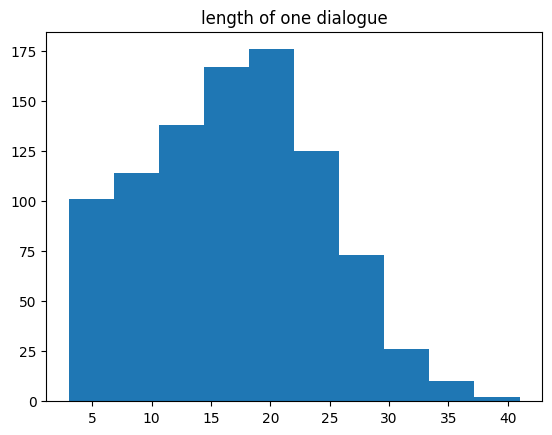

In [112]:
lens = [len(dia) for dia in new_data]
# length of one dialogue
plt.hist(lens)
plt.title('length of one dialogue')
plt.show()

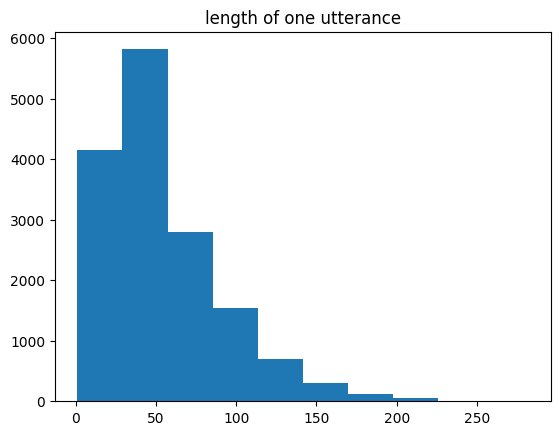

In [113]:
lens_uttr = [len(uttr['text']) for dia in new_data for uttr in dia]
# length of one utterance
plt.hist(lens_uttr)
plt.title('length of one utterance')
plt.show()

Pipeline:
1. select original dialogue
2. generate original graph based on original dialogue
3. select additional dialogue and add it to the original graph
4. validate result graph

In [ ]:
# select original dialogue, generate original graph
original_dialogue = [Dialogue.from_list(c) for c in new_data[:1]]
original_graph = graph_generator.invoke(original_dialogue)

In [ ]:
# select additional dialogue
additional_dialogue = [Dialogue.from_list(c) for c in [new_data[1]]]
dialogues = original_dialogue + additional_dialogue


### Service functions - code may not work

data is here - chatsky-llm-autoconfig/experiments/2025.01.22_sampler/data/

In [ ]:
def generate_graph_for_2_dialogues(
        first_graph_generator, second_graph_generator, dialogues, vis=True
        ):
    original_dialogue, additional_dialogue = [dialogues[0]], [dialogues[1]]

    # generate original graph
    try:
        print('Original graph generation...')
        original_graph = first_graph_generator.invoke(original_dialogue)

        if vis:
            original_graph.visualise_short("2 original_graph")
        # validate original graph
        print(validate_graph(original_graph, original_dialogue))

    except Exception as e:
        print(e)

    # add additional dialogue to the original graph
    try:
        print('Adding additional dialogue to the original graph...')
        if second_graph_generator == GeneratorI():
            result_graph, dialogues_ = second_graph_generator.invoke(additional_dialogue, original_graph)
        elif second_graph_generator == GeneratorI0():
            result_graph = second_graph_generator.invoke(additional_dialogue, original_graph)
        elif second_graph_generator == AppendChain():
            result_graph = second_graph_generator.invoke(dialogues, original_graph)

        if vis:
            result_graph.visualise_short("2 dialogues")
        # validate result graph
        val_report = validate_graph(result_graph, dialogues)
        
        return result_graph, val_report

    except Exception as e:
        print(e)

In [ ]:
#for example
result_graph, val_report = generate_graph_for_2_dialogues(
    Generator("o3-mini"), GeneratorI(), dialogues, original_graph, vis=True
    )
print(val_report)

# Simple data - checking pipeline

**Pipeline:**
1. select original dialogue
2. generate original graph based on original dialogue and validate it
3. select additional dialogue
4. add additional dialogue to the original graph and validate result graph

OR
1. select original dialogue
2. select additional dialogue (these dialogues have their true graph)
3. add additional dialogue to the true graph and validate result graph

In [5]:
original_dialogue = Dialogue(messages=[
    # DialogueMessage(text="Hello", participant="user"),
    DialogueMessage(text="Hello, how can I help?", participant="assistant"),
    DialogueMessage(text="I want to take a book", participant="user"),
    DialogueMessage(text="Which author are you interested in?", participant="assistant"),
    DialogueMessage(text="Arseniy Tarkovsky", participant="user"),
    DialogueMessage(text="Here you are", participant="assistant"),
])

additional_dialogue = Dialogue(messages=[
    # DialogueMessage(text="Hello", participant="user"),
    DialogueMessage(text="Hello, how can I help?", participant="assistant"),
    DialogueMessage(text="I want to take a magazine", participant="user"),
    DialogueMessage(text="Which magazine are you interested in?", participant="assistant"),
    DialogueMessage(text="Vogue", participant="user"),
    DialogueMessage(text="Which period are you interested in?", participant="assistant"),
    DialogueMessage(text="October 1987", participant="user"),
    DialogueMessage(text="Here you are", participant="assistant"),
])
dialogues = [original_dialogue, additional_dialogue]

original_graph = Graph(graph_dict={
    "nodes": [
        {
            "id": 1,
            "label": "start",
            "is_start": True,
            "utterances": [
                "Hello, how can I help?"
            ]
        },
        {
            "id": 2,
            "label": "ask_author",
            "is_start": False,
            "utterances": [
                "Which author are you interested in?"
            ]
        },
        {
            "id": 3,
            "label": "end",
            "is_start": False,
            "utterances": [
                "Here you are"
            ]
        },
    ],
    "edges": [
        {
            "utterances": [
                "I want to take a book"
            ],
            "source": 1,
            "target": 2
        },
        {
            "utterances": [
                "Arseniy Tarkovsky"
            ],
            "source": 2,
            "target": 3
        },
    ]
})

#### gpt-3.5-turbo

graph_generator_llm_emb - gpt-3.5-turbo is not enough to construct a graph

In [ ]:
# result_graph_llm_emb, dialogues_ = graph_generator_llm_emb.invoke(additional_dialogue, original_graph)

graph_generator_llm - gpt-3.5-turbo is able to generate a graph

In [ ]:
# add additional dialogue to the original graph and validate it
result_graph_llm = graph_generator_llm.invoke([additional_dialogue], original_graph)

model:   gpt-3.5-turbo
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


RES:  {'edges': [{'source': 1, 'target': 2, 'utterances': ['I want to take a book']}, {'source': 1, 'target': 2, 'utterances': ['Arseniy Tarkovsky']}, {'source': 2, 'target': 2, 'utterances': ['Vogue']}, {'source': 2, 'target': 2, 'utterances': ['October 1987']}], 'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello, how can I help?', 'I want to take a magazine', 'Which magazine are you interested in?', 'Which period are you interested in?', 'Here you are']}, {'id': 2, 'label': 'end', 'is_start': False, 'utterances': ['Vogue', 'October 1987']}]}
SKIP


graph_generator_llm_2 - gpt-3.5-turbo is able to generate a graph

In [ ]:
result_graph_llm_2 = graph_generator_llm_2.invoke(dialogues, original_graph)

In [15]:
with open("result_graph_llm_ThreeStagesGen.json", "w", encoding="utf-8") as file:
    json.dump(result_graph_llm.graph_dict, file, indent=4, sort_keys=True)

In [13]:
with open("result_graph_llm_AppendChain.json", "w", encoding="utf-8") as file:
    json.dump(result_graph_llm_2.graph_dict, file, indent=4, sort_keys=True)

#### o1-mini

o3-mini doesn't support temp, o1-mini supports only temp=1

In [6]:
result_graph_llm_emb_ThreeStagesGen, dialogues_ = graph_generator_llm_emb.invoke([additional_dialogue], original_graph)

model:   o1-mini
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 400 Bad Request"


Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.2 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}
error, retrying...
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 400 Bad Request"


Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.2 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}
error, retrying...
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 400 Bad Request"


Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.2 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}
error, retrying...


AttributeError: 'NoneType' object has no attribute 'model_dump'

In [7]:
result_graph_llm_ThreeStagesGen = graph_generator_llm.invoke([additional_dialogue], original_graph)

model:   o1-mini
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 400 Bad Request"


Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.0 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}
error, retrying...
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 400 Bad Request"


Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.0 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}
error, retrying...
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 400 Bad Request"


Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.0 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}
error, retrying...


AttributeError: 'NoneType' object has no attribute 'model_dump'

In [8]:
result_graph_llm_2 = graph_generator_llm_2.invoke(dialogues, original_graph)

model:   o1-mini
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 400 Bad Request"


Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.0 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}
error, retrying...
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 400 Bad Request"


Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.0 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}
error, retrying...
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 400 Bad Request"


Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.0 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}
error, retrying...


# Graph validation on simple data

In [10]:
def validate_graph(original_graph, result_graph):
    val_report = {}
    val_report['is_same_structure'] = is_same_structure(original_graph, result_graph)
    node_mapping, edge_mapping = triplet_match(original_graph, result_graph)
    val_report['triplet_match'] = {
        'node_mapping' : None,
        'edge_mapping' : None
        }
    val_report['triplet_match']['node_mapping'] = node_mapping
    val_report['triplet_match']['edge_mapping'] = edge_mapping
    
    return val_report

In [11]:
with open('result_graph_llm_ThreeStagesGen_gpt35turbo.json', 'r', encoding="utf-8") as f:
    result_graph_llm_dict = json.load(f)
result_graph_llm_ThreeStagesGen = Graph(graph_dict=result_graph_llm_dict)

val_report = validate_graph(original_graph, result_graph_llm_ThreeStagesGen)
val_report

BEFORE:  [(1, 2, {'theme': None, 'utterances': ['I want to take a book']}), (2, 3, {'theme': None, 'utterances': ['Arseniy Tarkovsky']})]
COLLAPSE:  {'1->2': ['I want to take a book'], '2->3': ['Arseniy Tarkovsky']}
(2, 2)
JACCA:  [(1, {'theme': None, 'label': 'start', 'utterances': ['Hello, how can I help?', 'I want to take a magazine', 'Which magazine are you interested in?', 'Which period are you interested in?', 'Here you are']}), (2, {'theme': None, 'label': 'end', 'utterances': ['Vogue', 'October 1987']})]
{1: ['Hello, how can I help?'], 2: ['Which author are you interested in?'], 3: ['Here you are']}


{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None, 2: None, 3: None},
  'edge_mapping': {'1->2': None, '2->3': None}}}

In [12]:
with open('result_graph_llm_AppendChain_gpt35turbo.json', 'r', encoding="utf-8") as f:
    result_graph_llm_dict = json.load(f)
result_graph_llm_AppendChain = Graph(graph_dict=result_graph_llm_dict)

val_report = validate_graph(original_graph, result_graph_llm_AppendChain)
val_report

BEFORE:  [(1, 2, {'theme': None, 'utterances': ['I want to take a book']}), (2, 3, {'theme': None, 'utterances': ['Arseniy Tarkovsky']})]
COLLAPSE:  {'1->2': ['I want to take a book'], '2->3': ['Arseniy Tarkovsky']}
(2, 5)
JACCA:  [(1, {'theme': None, 'label': 'start', 'utterances': ['Hello, how can I help?']}), (2, {'theme': None, 'label': 'ask_author', 'utterances': ['Which author are you interested in?']}), (3, {'theme': None, 'label': 'end', 'utterances': ['Here you are']}), (4, {'theme': None, 'label': 'ask_magazine', 'utterances': ['Which magazine are you interested in?']}), (5, {'theme': None, 'label': 'ask_period', 'utterances': ['Which period are you interested in?']})]
{1: ['Hello, how can I help?'], 2: ['Which author are you interested in?'], 3: ['Here you are']}


{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None},
  'edge_mapping': {'1->2': None, '2->3': None}}}

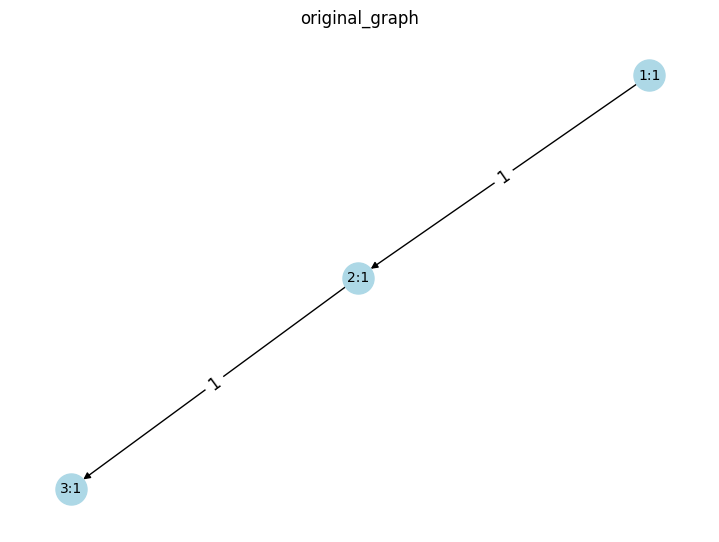

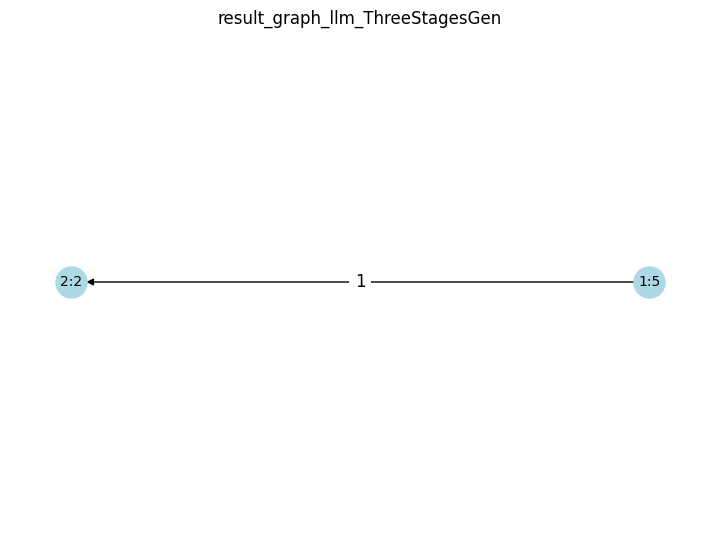

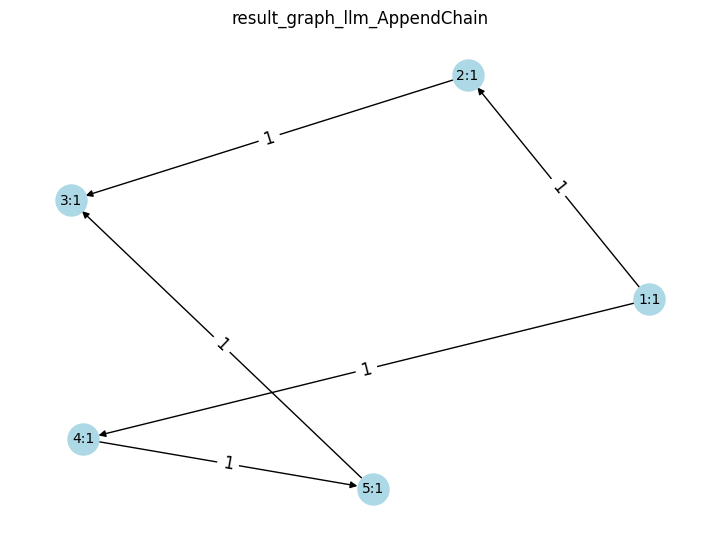

In [102]:
original_graph.visualise_short('original_graph')
result_graph_llm_ThreeStagesGen.visualise_short('result_graph_llm_ThreeStagesGen')
result_graph_llm_AppendChain.visualise_short('result_graph_llm_AppendChain')

**About triple_match report**
 - Just printed, not returned:

BEFORE:  [(1, 2, {'theme': None, 'utterances': ['I want to take a book'], 'attrs': 1}), (2, 3, {'theme': None, 'utterances': ['Arseniy Tarkovsky'], 'attrs': 1})]

COLLAPSE:  {'1->2': ['I want to take a book'], '2->3': ['Arseniy Tarkovsky']}

(2, 5)

JACCA:  [(1, {'theme': None, 'label': 'start', 'utterances': ['Hello, how can I help?']}), (2, {'theme': None, 'label': 'ask_author', 'utterances': ['Which author are you interested in?']}), (3, {'theme': None, 'label': 'end', 'utterances': ['Here you are']}), (4, {'theme': None, 'label': 'ask_magazine', 'utterances': ['Which magazine are you interested in?']}), (5, {'theme': None, 'label': 'ask_period', 'utterances': ['Which period are you interested in?']})]


{1: ['Hello, how can I help?'], 2: ['Which author are you interested in?'], 3: ['Here you are']}

- Returned:
```
{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None},
  'edge_mapping': {'1->2': None, '2->3': None}}}
  ```

There are corrections in the code of jaccard metrics which enables saving full report as a dict.

**Вопросы:** 
1. нормально ли то, что для таких простых графов получаем метрику 'is_same_structure'=False?
2. получены ли ожидаемые значения метрики 'triplet_match'?

# Generated dataset exploration

In [17]:
path = '/cephfs/home/olshevskaya/chatsky-llm-autoconfig/experiments/2025.01.22_sampler/data/generated_24.json'
with open(path, 'r', encoding="utf-8") as f:
    generated_24 = json.load(f)

Structure of data:

it is a list of dictionaries. One dict has 1 graph, 1 topic and several dialogues (sampled from this graph?).

One dialogue is a dictionary with keys ['messages', 'topic', 'validate']. Messages are messages, validate is a boolean value. 

There are 24 examples and 277 dialogues in total. Topic of all dialogues is an empty string. Validate of all dialogues is True.

In [ ]:
# collect topics, count dialogue and utterance length
topics, dia_lens, uttr_lens = [], [], []

for data in generated_24:
    for dia in data['dialogues']:
        topics.append(dia['topic'])
        dia_lens.append(len(dia['messages']))
        uttr_len = [len(msg['text']) for msg in dia['messages']]
        uttr_lens += uttr_len

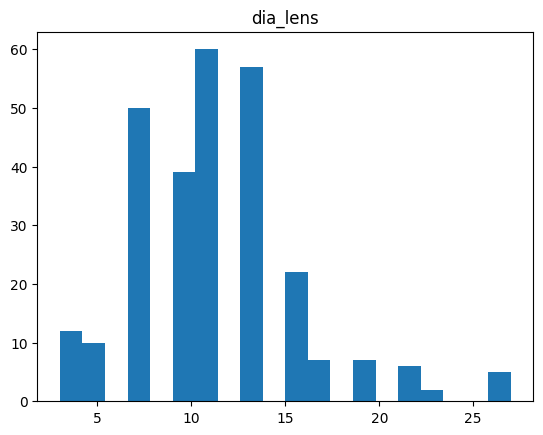

In [94]:
plt.title('dia_lens')
plt.hist(dia_lens, bins=20)
plt.show()

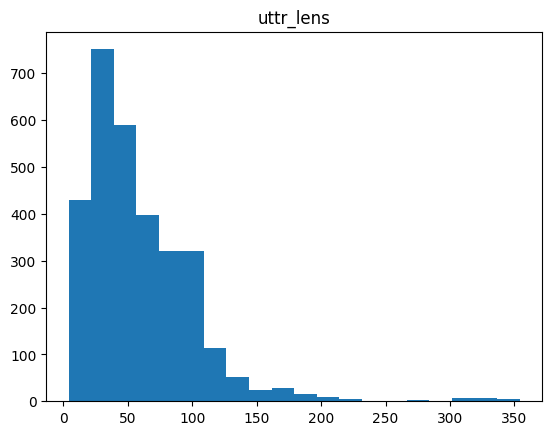

In [95]:
plt.title('uttr_lens')
plt.hist(uttr_lens, bins=20)
plt.show()

In [76]:
import numpy as np

In [79]:
np.min(dia_lens), np.mean(dia_lens), np.max(dia_lens)

(3, 11.108303249097473, 27)

In [78]:
np.min(uttr_lens), np.mean(uttr_lens), np.max(uttr_lens)

(4, 58.90932726681833, 354)

In [ ]:
# count number of dialogues per one graph
counter_dia_per_graph = []
for data in generated_24:
    count = len(data['dialogues'])
    counter_dia_per_graph.append(count)

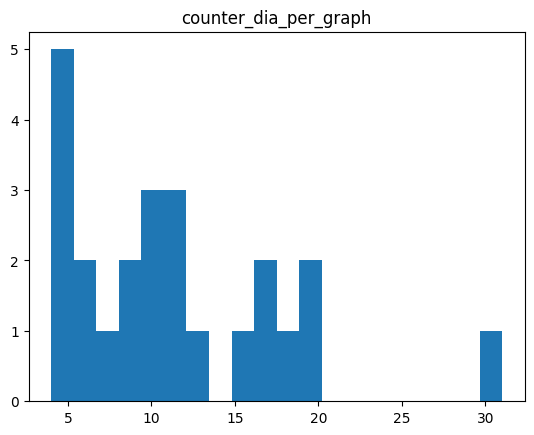

In [96]:
plt.title('counter_dia_per_graph')
plt.hist(counter_dia_per_graph, bins=20)
plt.show()

In [83]:
np.min(counter_dia_per_graph), np.mean(counter_dia_per_graph), np.max(counter_dia_per_graph)

(4, 11.541666666666666, 31)

What to do:

1. add graph id for identification
2. sample pairs of dialogues for graph incrementation
3. generate new data with the following structure:
    - keys: id, original_dialogue, additional_dialogue, true_graph, result_graph, validation_report
    - true_graph has graph_id, nodes, edges
    - result_graph has nodes, edges


Write:
1. function for each step (given we already have pairs of dialogues)
    - +/- generation of original graph
    - generation of result graph based on 2 dialogues
    - validation of result graph
2. code for generated dataset analytics
    - number of graphs, dialogues (total and per graph)
    - dialogue length, utterance length
    - distribution and ststistics
3. generate_and_validate for validation of each graph

Какие диалоги берем?

In [ ]:
# add graph id for identification
with open("generated_24_with_ids.json", "w", encoding="utf-8") as file:
    json.dump(generated_24, file, indent=4, sort_keys=True)

сколько диалогов имеют 10-15 реплик?

In [106]:
total_count = 0
for data in generated_24:
    count = 0
    for dia in data['dialogues']:
        if len(dia['messages']) >= 10 and len(dia['messages']) <= 15:
            count += 1
    print('graph', data['graph_id'], '- count:', count)
    total_count += count
total_count

graph 0 - count: 0
graph 1 - count: 10
graph 2 - count: 8
graph 3 - count: 2
graph 4 - count: 2
graph 5 - count: 7
graph 6 - count: 5
graph 7 - count: 16
graph 8 - count: 6
graph 9 - count: 1
graph 10 - count: 13
graph 11 - count: 5
graph 12 - count: 4
graph 13 - count: 1
graph 14 - count: 8
graph 15 - count: 0
graph 16 - count: 3
graph 17 - count: 18
graph 18 - count: 13
graph 19 - count: 1
graph 20 - count: 3
graph 21 - count: 0
graph 22 - count: 13
graph 23 - count: 0


139

# Вывод

**Пайплайн**:
1. выбрать исходный диалог
2. сгенерировать исходный граф на основе исх.диалога и валидировать его
3. выбрать дополнительный диалог
4. добавить доп.диалог к исходному графу и валидировать получившийся новый граф

ИЛИ
1. выбрать исходный диалог
2. выбрать дополнительный диалог (у этих диалогов уже есть их истинный граф)
3. добавить доп.диалог к истинному графу и валидировать получившийся новый граф

**Вопросы:**
1. какой пайплайн?
2. важны ли количество реплик в диалоге и длина реплик? берем по 2 диалога или больше?
3. вопрос о triplet_match - полный/краткий отчет? метрики соответствуют ожиданиям? (пример выше)
4. кода triplet_match_accuracy пока нет - можно ли ее будет потом посчитать по результатам triplet_match? или нужно ее считать сразу
5. какие модели? 


In [117]:
print(original_graph.edges_match_nodes())
print(result_graph_llm_AppendChain.edges_match_nodes())
print(result_graph_llm_ThreeStagesGen.edges_match_nodes())

True
True
True


In [118]:
print(original_graph.remove_duplicated_nodes())
print(result_graph_llm_AppendChain.remove_duplicated_nodes())
print(result_graph_llm_ThreeStagesGen.remove_duplicated_nodes())

graph_dict={'edges': [{'utterances': ['I want to take a book'], 'source': 1, 'target': 2}, {'utterances': ['Arseniy Tarkovsky'], 'source': 2, 'target': 3}], 'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello, how can I help?']}, {'id': 2, 'label': 'ask_author', 'is_start': False, 'utterances': ['Which author are you interested in?']}, {'id': 3, 'label': 'end', 'is_start': False, 'utterances': ['Here you are']}]} graph=<networkx.classes.digraph.DiGraph object at 0x7f89f4c0f610> node_mapping={}
graph_dict={'edges': [{'source': 1, 'target': 2, 'utterances': ['I want to take a book']}, {'source': 2, 'target': 3, 'utterances': ['Arseniy Tarkovsky']}, {'source': 1, 'target': 4, 'utterances': ['I want to take a magazine']}, {'source': 4, 'target': 5, 'utterances': ['Vogue']}, {'source': 5, 'target': 3, 'utterances': ['October 1987']}], 'nodes': [{'id': 1, 'is_start': True, 'label': 'start', 'utterances': ['Hello, how can I help?']}, {'id': 2, 'is_start': False, 'lab